# Workflow Scheduling Problem

Consider an optimization problem (based on the formulation in [[1](#TaskWorkflow)]): there are $W(t)$ available workers or resources and $N$ jobs, where each job $j$ requires $T(j)$ time and takes $r(j)$ resources to be completed. Given a set of dependencies for each job and that you know which job depends on the completion of others before starting, determine the order of job completion that minimizes the total execution time.

Assumptions:
- A job may occupy only a single timeslot at most: $\forall j \,\,\, T(j) = 1$
- Given sufficient resources, jobs can start in the same timeslot
- All resources are identical and the amount of available resources at a current time step is given by the number $W(t)$
- Jobs can only start if all parent jobs are complete

Possible extensions:
- Separate resources into multiple categories with jobs requiring different types
- Jobs that take more than one operation

## Mathematical Modeling

The input of the model is as follows:

Define a binary variable for the optimization problem: an $t_{max}\times N$ matrix $x$ such that
$\begin{aligned}
x_{tj} =
\begin{cases}
      1 & \text{job } j \text{ is done on the } t_\text{th} \text{ time slot} \\
      0 & \text{else}
\end{cases}\\
\end{aligned}$

Constraints:

- All jobs must complete exactly once: $\forall j\in[1,N] \,\,\, \sum_t x_{tj}=1$

- All jobs may use no more than the available resources: $\forall t\in[0,t_{max}] \,\,\, \sum_j x_{tj} r_j \leq W_t$

- Parent jobs must be complete before dependent jobs start: $x_{t_1j_1} x_{t_2j_2} = 0 \,\,\, \forall j_1, t_1\leq t_2, j_2 \text{ depends on } j_1$


The objective function to minimize is the total cost function:
$$
\min_{x} \sum_{t} x_{tN}\cdot t
$$
which favors schedules that are done early.

## Defining the Optimization Model

In [1]:
from typing import List, Tuple, cast  # noqa

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np  # noqa
import pandas as pd
import pyomo.environ as pyo
from IPython.display import Markdown, display

In [2]:
def define_workflow_problem(
    G, num_timeslots, available_capacities, work_loads
) -> pyo.ConcreteModel:
    model = pyo.ConcreteModel("task_scheduling")

    timeslots = range(num_timeslots)
    assert len(timeslots) == len(available_capacities)
    works = range(len(G.nodes))
    assert len(works) == len(work_loads)

    last_works = [node for node in G.nodes if G.out_degree(node) == 0]
    assert len(last_works) == 1
    last_work = last_works[0]
    # works with no dependancies
    root_works = [node for node in G.nodes if G.in_degree(node) == 0]

    model.x = pyo.Var(timeslots, works, domain=pyo.Binary)

    @model.Constraint(works)
    def all_works_are_done(model, i):  # constraint (1)
        return sum(model.x[t, i] for t in timeslots) == 1

    @model.Constraint(timeslots)
    def capacity_is_valid(model, t):  # constraint(2)
        return (
            sum(model.x[t, i] * work_loads[i] for i in works) <= available_capacities[t]
        )

    @model.Constraint(works, works, timeslots, timeslots)
    def works_done_by_their_order(model, i, j, t1, t2):  # constraint (3)
        if G.has_edge(i, j) and t1 >= t2:
            return model.x[t1, i] * model.x[t2, j] == 0
        return pyo.Constraint.Feasible

    # eliminate all timeslots that are not possible for the task in order to save qubits
    distances_from_ends = nx.floyd_warshall_numpy(G)
    distances_from_roots = nx.floyd_warshall_numpy(G.reverse())

    @model.Constraint(works, timeslots)
    def eliminating_rule(model, i, t):
        end_distance = int(np.min(distances_from_ends[i, last_works]))
        start_distance = int(np.min(distances_from_roots[i, root_works]))
        if (t < start_distance) or (t >= len(timeslots) - end_distance):
            return model.x[t, i] == 0
        return pyo.Constraint.Feasible

    # minimize the end time of the last work
    model.cost = pyo.Objective(
        expr=sum(model.x[t, last_work] * (t + 1) for t in timeslots), sense=pyo.minimize
    )

    return model

Visualization helper functions:

In [3]:
import random


def plot_graph(solution=None, ax=None):
    if solution is not None:
        # determine how many tasks start in each timeslot
        num_tasks = [sum(solution[t]) for t in range(num_timeslots)]
        max_tasks = max(num_tasks)

        pos = {}

        # find all the tasks that start in particular start time
        for start in np.nonzero(solution.sum(axis=1))[0]:
            locations = solution[start].nonzero()[0]
            pos.update(
                {
                    n: (start, i + (max_tasks - num_tasks[start]) / 2)
                    for i, n in enumerate(locations)
                }
            )
    else:
        pos = {
            node: (order, random.random())
            for order, node in enumerate((nx.topological_sort(G)))
        }

    options = {
        "font_size": 12,
        "node_size": 1000,
        "node_color": "white",
        "edgecolors": "black",
        "linewidths": 3,
        "width": 3,
    }
    # G = nx.DiGraph(edges)
    nx.draw_networkx(G, pos, ax=ax, **options)

    # Set margins for the axes so that nodes aren't clipped
    if ax is None:
        ax = plt.subplot()
    ax.margins(0.20)
    if solution is not None:
        ax.set_title("Suggested sequence")
    ax.set_xlabel("Timeslot")


def plot_assignments(solution, ax=None):
    if ax is None:
        ax = plt.subplot()
    ax.pcolormesh(solution.T, edgecolors="w", linewidth=4, cmap="OrRd")
    ax.set_aspect(0.8)
    ax.set_xlabel("Timeslot")
    ax.set_ylabel("Task Number")
    ax.set_title("Task assignment")


def plot_resource_graph(solution=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    x_pos = np.arange(len(capacities))
    if solution is not None:
        ax.set_title("Utilization")
        num_resources = [np.dot(solution[t], workloads) for t in range(num_timeslots)]
        ax.bar(x_pos + 0.1, num_resources, label="used resources", color="r", width=0.5)
    ax.bar(x_pos, capacities, label="available_resources", color="g", width=0.5)
    ax.set_xticks(x_pos)
    ax.legend()
    ax.set_xlabel("Timeslot")
    ax.set_ylabel("Resources")


def plot_workloads(ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_title("Work Loads")
    x_pos = np.arange(len(workloads))
    ax.bar(x_pos, workloads, width=0.5)
    ax.set_xticks(x_pos)
    ax.set_xlabel("Jobs")
    ax.set_ylabel("Required Resources")


def is_printable_solution(solution):
    return np.array_equal(solution.sum(axis=0), np.ones(solution.shape[1]))


def plot_workflow(solution=None):
    if solution is None:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        plot_resource_graph(ax=axes[0])
        plot_graph(ax=axes[1])
        plot_workloads(ax=axes[2])

    else:
        if is_printable_solution(solution):
            fig, axes = plt.subplots(2, 2, figsize=(12, 10))
            plot_resource_graph(solution, axes[0, 0])
            plot_workloads(axes[0, 1])
            plot_assignments(solution, axes[1, 1])
            plot_graph(solution, axes[1, 0])
        else:
            # illegal solution
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))
            plot_resource_graph(solution, axes[0])
            plot_workloads(axes[1])
            plot_assignments(solution, axes[2])

## Initializing a Specific Problem Instance

Create a workflow dependencies graph. For the small instance, all timeslot capacities and workloads are equal to each other:

In [4]:
def small_example():
    G = nx.DiGraph()

    nodes = range(4)
    edges = [(0, 1), (1, 3), (2, 3)]
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    num_timeslots = len(G.nodes) - 1
    capacities = 3 * np.ones(num_timeslots)
    workloads = np.ones(len(nodes))

    return (
        define_workflow_problem(
            G, num_timeslots, available_capacities=capacities, work_loads=workloads
        ),
        G,
        num_timeslots,
        capacities,
        workloads,
    )


def large_example():
    G = nx.DiGraph()

    nodes = range(6)
    edges = [(0, 1), (0, 3), (0, 2), (2, 4), (3, 4), (1, 5), (4, 5)]
    workloads = [1, 3, 2, 2, 1, 1]
    capacities = [1, 3, 4, 3, 1]
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    num_timeslots = len(capacities)

    return (
        define_workflow_problem(
            G, num_timeslots, available_capacities=capacities, work_loads=workloads
        ),
        G,
        num_timeslots,
        capacities,
        workloads,
    )

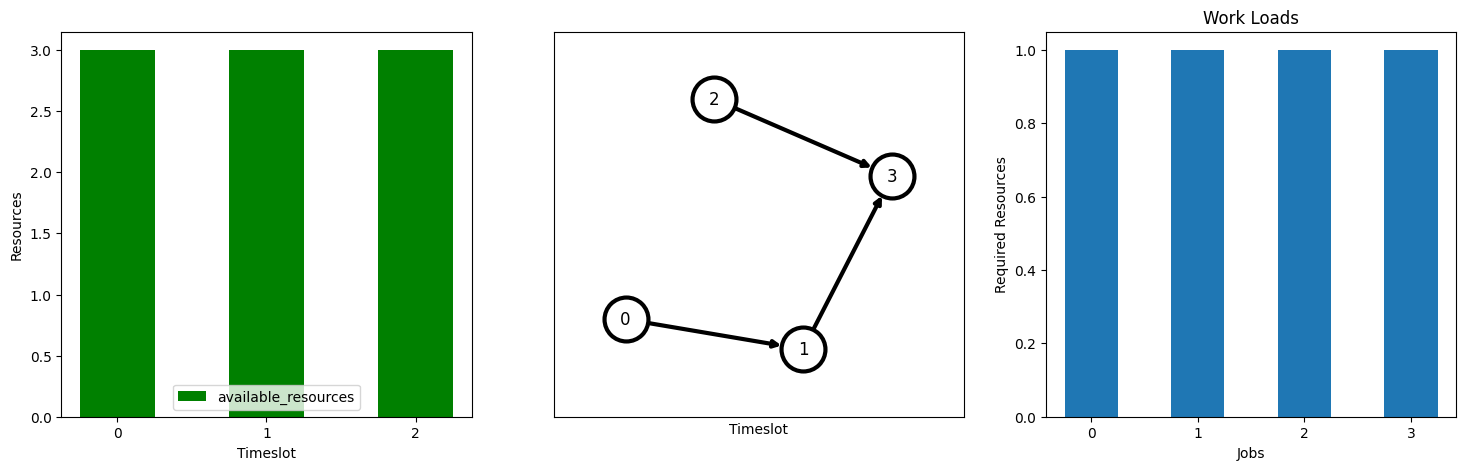

In [5]:
tasks_model, G, num_timeslots, capacities, workloads = small_example()
plot_workflow()

This is the resulting Pyomo model:

In [6]:
tasks_model.pprint()

1 Var Declarations
    x : Size=12, Index={0, 1, 2}*{0, 1, 2, 3}
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (0, 0) :     0 :  None :     1 : False :  True : Binary
        (0, 1) :     0 :  None :     1 : False :  True : Binary
        (0, 2) :     0 :  None :     1 : False :  True : Binary
        (0, 3) :     0 :  None :     1 : False :  True : Binary
        (1, 0) :     0 :  None :     1 : False :  True : Binary
        (1, 1) :     0 :  None :     1 : False :  True : Binary
        (1, 2) :     0 :  None :     1 : False :  True : Binary
        (1, 3) :     0 :  None :     1 : False :  True : Binary
        (2, 0) :     0 :  None :     1 : False :  True : Binary
        (2, 1) :     0 :  None :     1 : False :  True : Binary
        (2, 2) :     0 :  None :     1 : False :  True : Binary
        (2, 3) :     0 :  None :     1 : False :  True : Binary

1 Objective Declarations
    cost : Size=1, Index=None, Active=True
        Key  : Active : Sense    :

## Optimization Model with Hybrid Classical/Quantum QAOA

### Setting Up the Classiq Problem Instance

To solve the Pyomo model defined above, use the Classiq combinatorial optimization engine. For the quantum part of the Quantum Approximate Optimization Algorithm (QAOA) algorithm (`QAOAConfig`), define the number of repetitions (`num_layers`):

In [7]:
from classiq import *
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig

qaoa_config = QAOAConfig(num_layers=8, penalty_energy=20)

For the classical optimization part of the QAOA algorithm, define the maximum number of classical iterations (`max_iteration`) and the $\alpha$-parameter (`alpha_cvar`) for running CVaR-QAOA, an improved variation of the QAOA algorithm [[3](#cvar)]:

In [8]:
optimizer_config = OptimizerConfig(max_iteration=20, alpha_cvar=0.3)

Load the model based on the problem and algorithm parameters, which you can use to solve the problem:

In [9]:
qmod = construct_combinatorial_optimization_model(
    pyo_model=tasks_model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

### Synthesizing the QAOA Circuit and Solving the Problem

Synthesize and view the QAOA circuit (ansatz) used to solve the optimization problem:

In [10]:
qprog = synthesize(qmod)
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/39FfbEQz0qOc4MaJlwPJ5w3xgbp


https://platform.classiq.io/circuit/39FfbEQz0qOc4MaJlwPJ5w3xgbp?login=True&version=17

Solve the problem by calling the `execute` function on the quantum program you generated:

In [11]:
result = execute(qprog).result_value()

### Analyzing the Results

Check the convergence of the run:

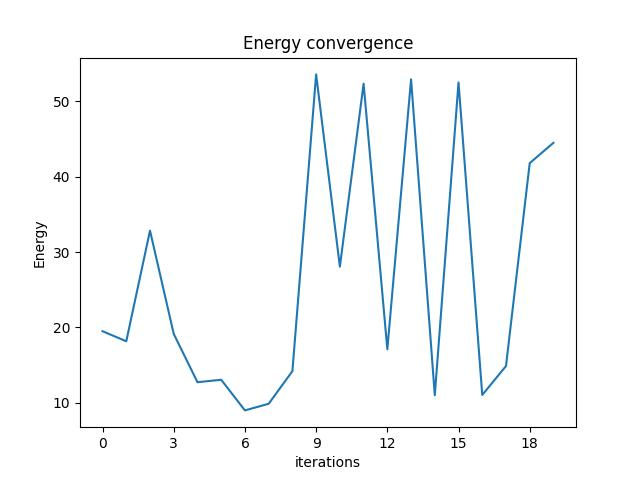

In [12]:
result.convergence_graph

Print the optimization results:

In [13]:
import pandas as pd

from classiq.applications.combinatorial_optimization import (
    get_optimization_solution_from_pyo,
)

solution = get_optimization_solution_from_pyo(
    tasks_model, vqe_result=result, penalty_energy=qaoa_config.penalty_energy
)
optimization_result = pd.DataFrame.from_records(solution)
optimization_result.sort_values(by="cost", ascending=True).head(5)

,probability,cost,solution,count
3,0.055176,3.0,"[1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]",113
6,0.048828,3.0,"[0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0]",100
5,0.053223,3.0,"[1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0]",109
4,0.053223,3.0,"[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]",109
7,0.035645,23.0,"[0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]",73


In [14]:
idx = optimization_result.cost.idxmin()
print(
    "x =", optimization_result.solution[idx], ", cost =", optimization_result.cost[idx]
)

x = [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0] , cost = 3.0


And the histogram:

array([[<Axes: title={'center': 'cost'}>]], dtype=object)

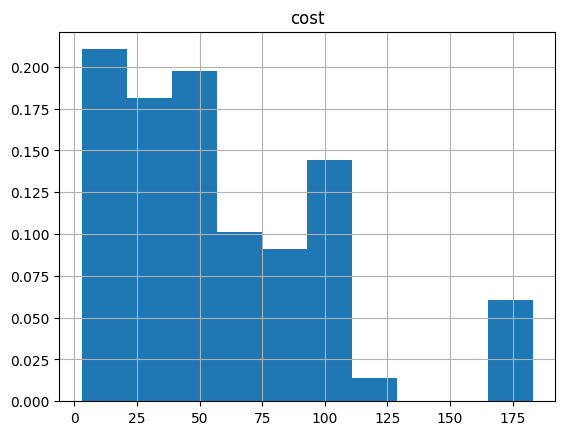

In [15]:
optimization_result.hist("cost", weights=optimization_result["probability"])

This is the best solution:

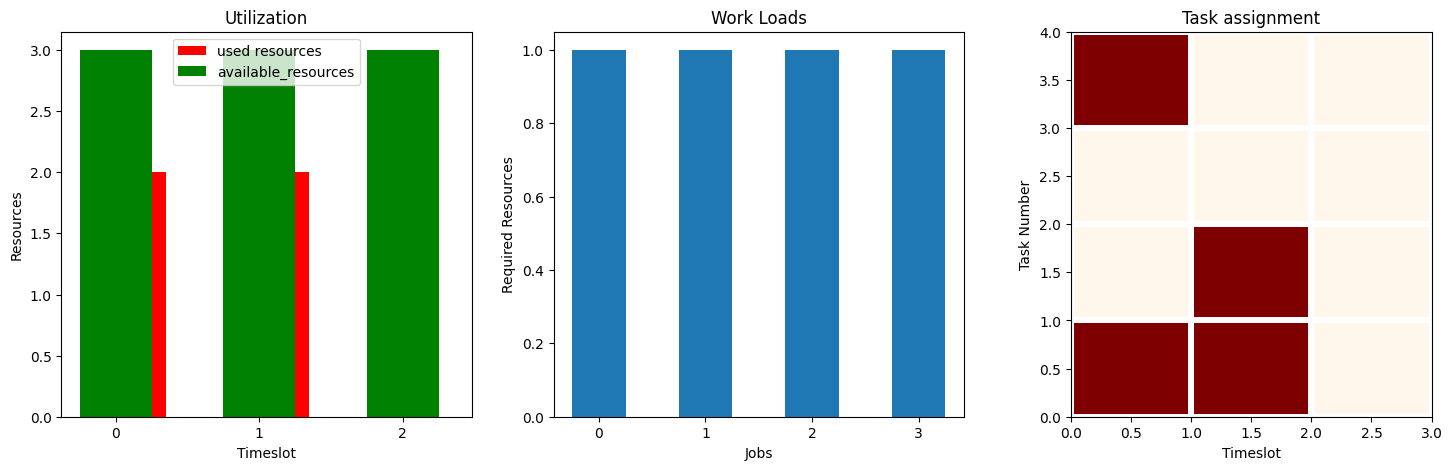

In [16]:
qaoa_solution = np.array(
    optimization_result.solution[optimization_result.cost.idxmin()]
).reshape(num_timeslots, len(G.nodes))
plot_workflow(qaoa_solution)

### Comparing to a Classical Optimizer Result

In [17]:
from pyomo.opt import SolverFactory

solver = SolverFactory("couenne")
solver.solve(tasks_model)

tasks_model.display()

Model task_scheduling

  Variables:
    x : Size=12, Index={0, 1, 2}*{0, 1, 2, 3}
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (0, 0) :     0 :   1.0 :     1 : False : False : Binary
        (0, 1) :     0 :   0.0 :     1 : False : False : Binary
        (0, 2) :     0 :   1.0 :     1 : False : False : Binary
        (0, 3) :     0 :   0.0 :     1 : False : False : Binary
        (1, 0) :     0 :   0.0 :     1 : False : False : Binary
        (1, 1) :     0 :   1.0 :     1 : False : False : Binary
        (1, 2) :     0 :   0.0 :     1 : False : False : Binary
        (1, 3) :     0 :   0.0 :     1 : False : False : Binary
        (2, 0) :     0 :   0.0 :     1 : False : False : Binary
        (2, 1) :     0 :   0.0 :     1 : False : False : Binary
        (2, 2) :     0 :   0.0 :     1 : False : False : Binary
        (2, 3) :     0 :   1.0 :     1 : False : False : Binary

  Objectives:
    cost : Size=1, Index=None, Active=True
        Key  : Active : Valu

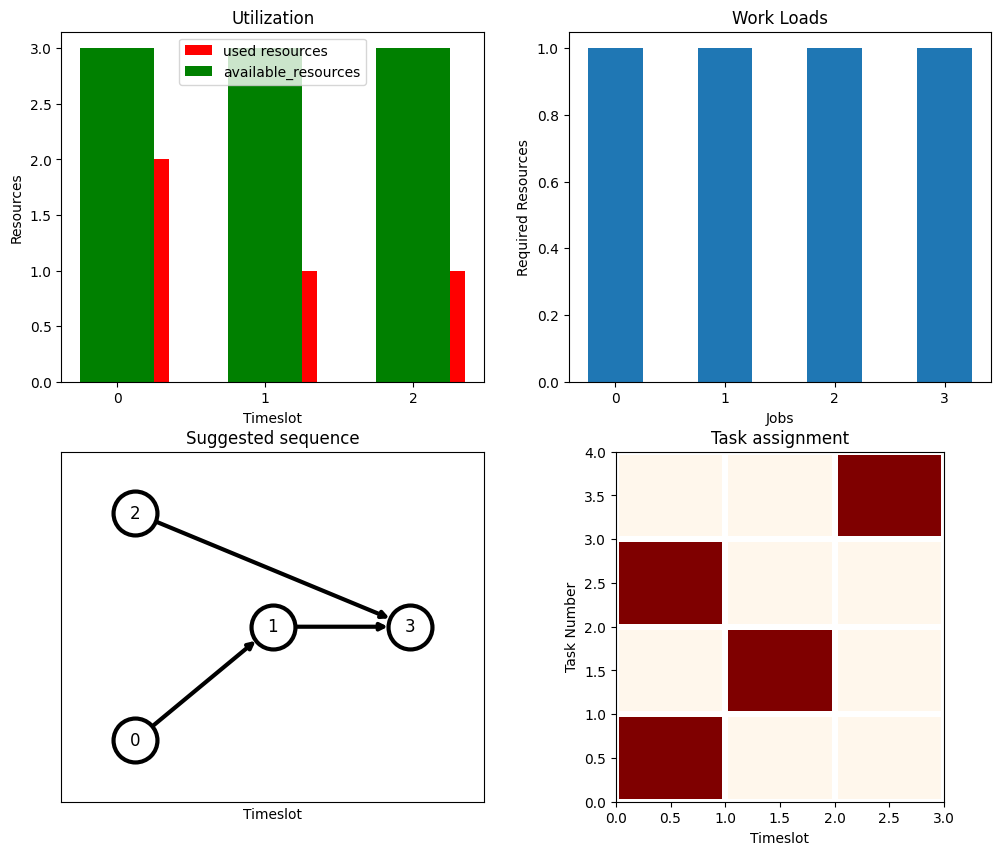

In [18]:
classical_solution = np.array(
    [
        int(pyo.value(tasks_model.x[idx]))
        for idx in np.ndindex(num_timeslots, len(G.nodes))
    ]
).reshape(num_timeslots, len(G.nodes))
plot_workflow(classical_solution)

## Large Example

Consider a more elaborate example, involving work with non-uniform workloads and resources:

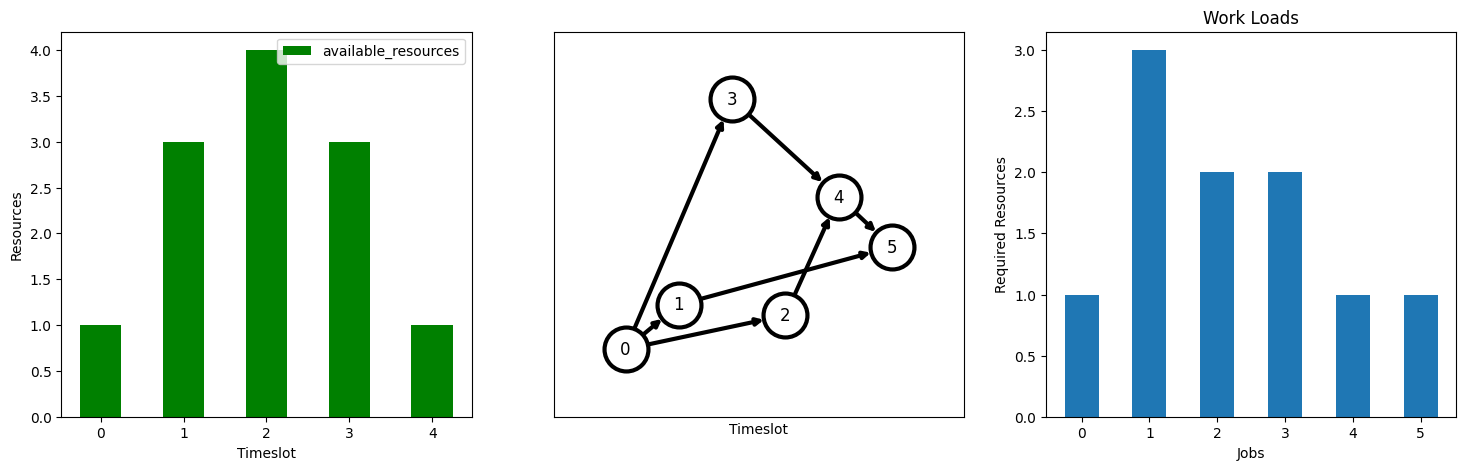

In [19]:
tasks_model_large, G, num_timeslots, capacities, workloads = large_example()
plot_workflow()

In [20]:
tasks_model_large.pprint()

1 Var Declarations
    x : Size=30, Index={0, 1, 2, 3, 4}*{0, 1, 2, 3, 4, 5}
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (0, 0) :     0 :  None :     1 : False :  True : Binary
        (0, 1) :     0 :  None :     1 : False :  True : Binary
        (0, 2) :     0 :  None :     1 : False :  True : Binary
        (0, 3) :     0 :  None :     1 : False :  True : Binary
        (0, 4) :     0 :  None :     1 : False :  True : Binary
        (0, 5) :     0 :  None :     1 : False :  True : Binary
        (1, 0) :     0 :  None :     1 : False :  True : Binary
        (1, 1) :     0 :  None :     1 : False :  True : Binary
        (1, 2) :     0 :  None :     1 : False :  True : Binary
        (1, 3) :     0 :  None :     1 : False :  True : Binary
        (1, 4) :     0 :  None :     1 : False :  True : Binary
        (1, 5) :     0 :  None :     1 : False :  True : Binary
        (2, 0) :     0 :  None :     1 : False :  True : Binary
        (2, 1) :     0 :  N

In [21]:
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig

qaoa_config = QAOAConfig(num_layers=8, penalty_energy=20.0)

optimizer_config = OptimizerConfig(max_iteration=1, alpha_cvar=0.6)

qmod_large = construct_combinatorial_optimization_model(
    pyo_model=tasks_model_large,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

In [22]:
qprog_large = synthesize(qmod_large)
show(qprog_large)

Quantum program link: https://platform.classiq.io/circuit/39FfeKokUbzIq6HFfGFArUCVNsL


https://platform.classiq.io/circuit/39FfeKokUbzIq6HFfGFArUCVNsL?login=True&version=17

In [23]:
result_large = execute(qprog_large).result_value()

As the search space here is much larger and involves many qubits, the optimizer takes much more time and might not converge to a legal solution.

Print the optimization results:

In [24]:
import pandas as pd

from classiq.applications.combinatorial_optimization import (
    get_optimization_solution_from_pyo,
)

solution = get_optimization_solution_from_pyo(
    tasks_model_large,
    vqe_result=result_large,
    penalty_energy=qaoa_config.penalty_energy,
)
optimization_result = pd.DataFrame.from_records(solution)
optimization_result.sort_values(by="cost", ascending=True).head(5)

,probability,cost,solution,count
217,0.000488,60.0,"[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...",1
1009,0.000488,80.0,"[1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...",1
265,0.000488,83.0,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...",1
934,0.000488,100.0,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...",1
1265,0.000488,104.0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...",1


In [25]:
idx = optimization_result.cost.idxmin()
print(
    "x =", optimization_result.solution[idx], ", cost =", optimization_result.cost[idx]
)

x = [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0] , cost = 60.0


And the histogram:

array([[<Axes: title={'center': 'cost'}>]], dtype=object)

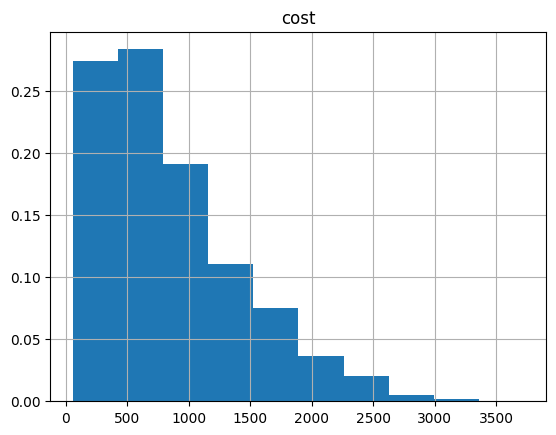

In [26]:
optimization_result.hist("cost", weights=optimization_result["probability"])

This is the best solution:

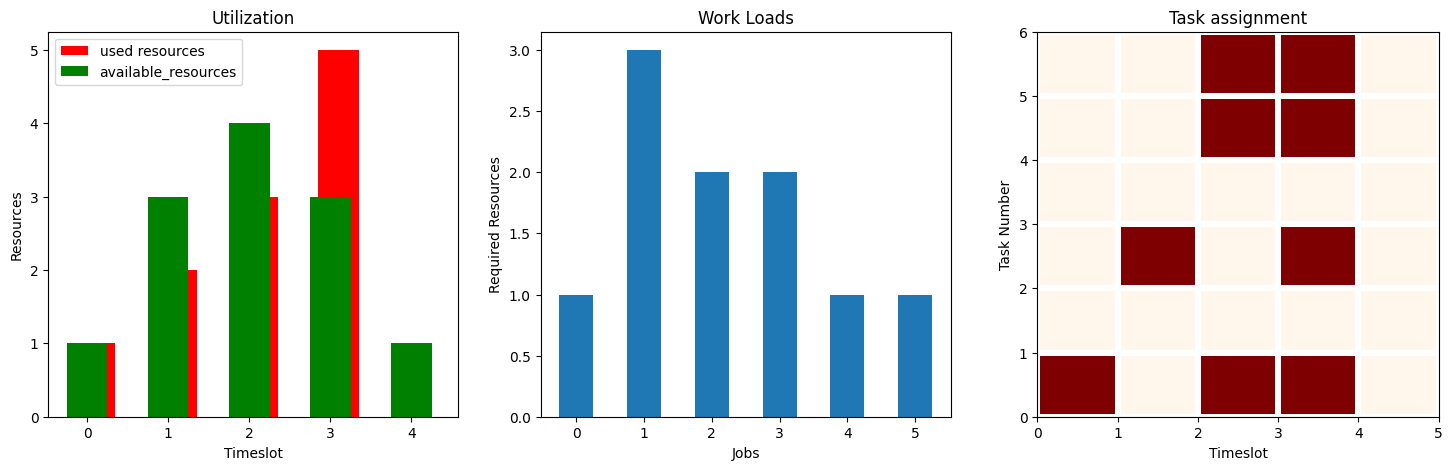

In [27]:
qaoa_solution_large = np.array(
    optimization_result.solution[optimization_result.cost.idxmin()]
).reshape(num_timeslots, len(G.nodes))
plot_workflow(qaoa_solution_large)

### Classical Solution for the Large Problem

In [28]:
from pyomo.opt import SolverFactory

solver = SolverFactory("couenne")
solver.solve(tasks_model_large)

tasks_model_large.display()

Model task_scheduling

  Variables:
    x : Size=30, Index={0, 1, 2, 3, 4}*{0, 1, 2, 3, 4, 5}
        Key    : Lower : Value                  : Upper : Fixed : Stale : Domain
        (0, 0) :     0 :                    1.0 :     1 : False : False : Binary
        (0, 1) :     0 :                    0.0 :     1 : False : False : Binary
        (0, 2) :     0 :                    0.0 :     1 : False : False : Binary
        (0, 3) :     0 :                    0.0 :     1 : False : False : Binary
        (0, 4) :     0 :                    0.0 :     1 : False : False : Binary
        (0, 5) :     0 :                    0.0 :     1 : False : False : Binary
        (1, 0) :     0 :                    0.0 :     1 : False : False : Binary
        (1, 1) :     0 :                    1.0 :     1 : False : False : Binary
        (1, 2) :     0 :                    0.0 :     1 : False : False : Binary
        (1, 3) :     0 :                    0.0 :     1 : False : False : Binary
        (1, 4) 

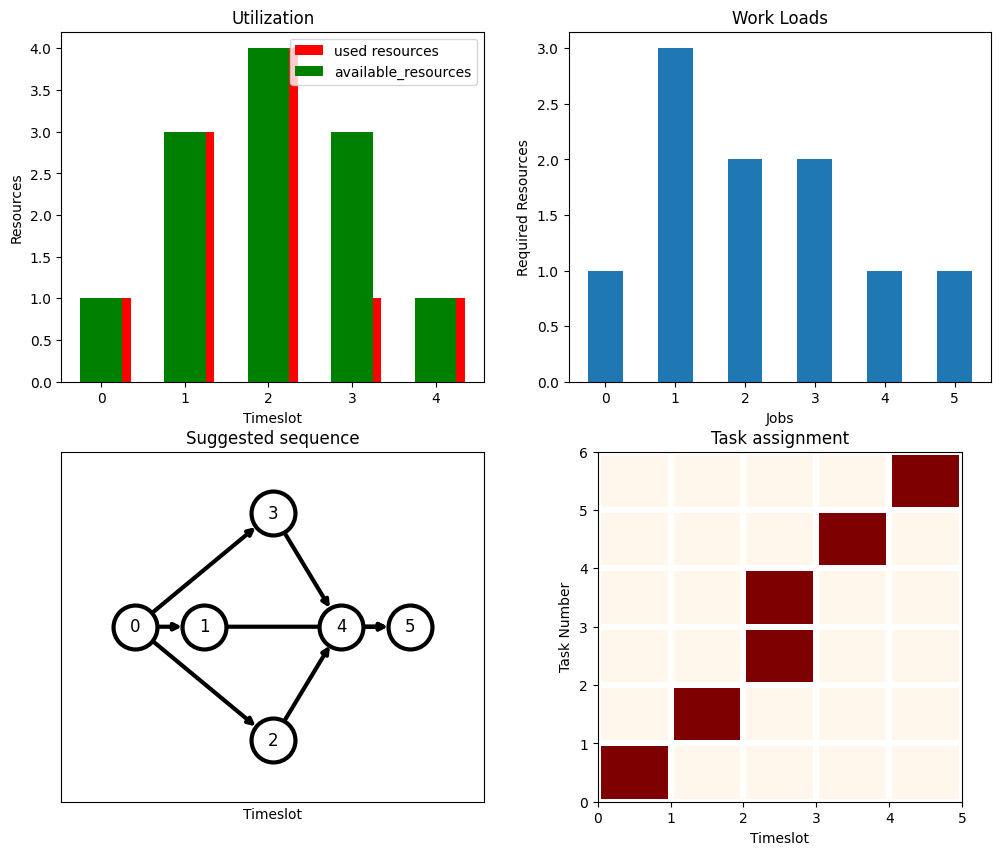

In [29]:
classical_solution = np.array(
    [
        int(pyo.value(tasks_model_large.x[idx]))
        for idx in np.ndindex(num_timeslots, len(G.nodes))
    ]
).reshape(num_timeslots, len(G.nodes))
plot_workflow(classical_solution)

## References

<a id='TaskWorkflow'>[1]</a> [Pakhomchik et. al. (2022). Solving workflow scheduling problems with QUBO modeling. arXiv preprint arXiv:2205.04844.](https://arxiv.org/pdf/2205.04844.pdf)
